# Presentation

#### Goal: Predict the number of nights granted to a request (not to an individual)


#### Caracteristics of the model:
Accuracy:
- if used as a clearing tool removing overburden upfront, and thus only to get rid of obvious cases, the accuracy of such a tool could be its most important caracteristic.

Interpretability:
- could help families understand the decision (although not as important as in diseases predictions).
- can also highlight and thus control biases (racial, sex, age).
- since the tool would probably be used in combination with human selection, it could help save time by highlighting the main factors for each decision

#### Conclusion:
- a model easily interpretable could be prefered (tree).
- or a highly accurate model (less interpretable) could also be used upfront (NN).


#### Future improvements

Imputations:
- Build more robust, generalisable imputations (eg. impute future test samples with missing gender based on all easily interpretable categories group_composition_label and group_composition_id)

- Automate NaNs imputation for future test samples

- Reconstruct some NaNs by training models to predict the feature


Datasets handling
- I made the choice to keep the train and test sets split. This is to prevent gaining insight from the test set while doing pre-processing, analysis and while training the model. To prevent duplicate code, I thus placed most of the inner workings in the class Analysis, which makes the reading less fluent. To improve, see how to better combine the visual aspect of Jupyter Notebooks, while maintaining code standards like DRY philosophy.


Pre-processing
- impact historical data with the known global crises (financial crisis, immigration waves)

# Plan

I. Initialization

1. Import packages, classes, functions

2. Load databases (no join)

3. Instantiate object Analysis


II. Analyze I

1. Overview

2. Features: corr, dist, impact


III. Pre-process data

1. Impute NaNs

2. Impute never seen before test set NaNs

3. Remove outliers

4. Transform categorical features

5. Feature engineer



IV. Analyze II

1. Impact engineered features


V. Build Model

1. Benchmakrs

2. Rush pytorch NN

3. Simple model using principal components

4. Ensemble


VI. Predictions

1. Train and Predict

2. Hyperparameter tunning (split train set)


VII. Evaluate methods


# Initialization

## Imports

In [ ]:
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, functional
from torch import nn, optim

# Utils
import cobratools as cobra

## Settings

In [ ]:
# Set False to only apply data transformations
ANALYZE_ON = False

# False for the competition, True if predicting > year 2019 requests
FUTURE_PRED = False

# Takes ±4min
IMPUTE_NANS = True
EXPORT_DATA = False

# Set to True to visualize
PRINT_ON = False
PLOT_ON = False

# Debug
RELOAD = False

# Data specificities
TARGET_VAR = 'granted_number_of_nights'
N_TARGET_CLASS = 4

## Debug reload
Without the need to re-perform data transformations

In [ ]:
if RELOAD:
    # Backup data
    backup_train = obj_train.df.copy()
    backup_test = obj_test.df.copy()
    
    # Reload updated class and functions
    importlib.reload(cobra)

    # Re-instanciate obj_train and obj_test
    obj_train = cobra.Analysis(backup_train)
    obj_test = cobra.Analysis(backup_test)
    
    # Re-set target variable
    obj_train.target = TARGET_VAR
    obj_test.target = TARGET_VAR

## Load data

In [ ]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

## Join datasets

Since there are multiple requests by individuals and multiple individuals by request, the straightfoward approach would be to create columns for each individual' informations. This way, no information would be lost, but the curse of dimensionality is very near and the number of samples might be too low to extract useful information.

The chosen approach is rather to only keep the request dataset' columns, and feature engineer additional columns based on the individuals data, eg.:
- nb of past requests made by the same individual
- nb nights granted in past requests of the same individual(s)/group
- gender diversity of the group
- etc.

However, for analytics purpose, a dataframe with all the data is also created.

In [ ]:
# Merge request and individuals datasets, for analytics purpose only
df_full_train = pd.merge(requests_train, individuals_train, on='request_id')

In [ ]:
# Set index col as request id
# (not for individuals data set, since there is no pkey currently)
# (hence not for obj_full_train either)
requests_train.set_index('request_id', inplace=True)
requests_test.set_index('request_id', inplace=True)

## Instantiate object analysis

obj_train and obj_test will be the main dataframes, used for training and testing the model

They are primilary built with the request data sets, then features engineered from individuals' data sets are added

In [ ]:
# Instantiate analysis object with request data
obj_train = cobra.Analysis(requests_train)
obj_test = cobra.Analysis(requests_test)
obj_full_train = cobra.Analysis(df_full_train)

# Define properties

# - set target
obj_train.target = TARGET_VAR
obj_full_train.target = TARGET_VAR

# - set shape
obj_train.m = obj_train.df.shape[0]
obj_test.m = obj_test.df.shape[0]
obj_train.n = obj_train.df.shape[1]
obj_test.n = obj_test.df.shape[1]
obj_full_train.m = obj_full_train.df.shape[0]
obj_full_train.n = obj_full_train.df.shape[1]

# Analysis I

Overview

- Number of requests: 238191

- Number of individuals: 384133

- Number of features: 39

- Requests are made for 1.6 pers on average.


Principal components
- housing_situation_label: with value "emergency accomodation". High probability to get 1 or two nights. Logical since the service treats emergency housing
- housing_situation_2_label: with value "emergency accomodation". High probability to get 1 or two nights.

--------------------


Analysis by features


A. housing_situation_id
- correlation target-housing_situation_id: -0.458581. Strong negative impact. Although the linear numerical relation of the housing_situation_id categories is in my opinion flawed, the strong correlation is explainable as the category with the smallest value "emergency accomodation" might be correlated with higher granted_number_of_nights than the rest of the categories, which happen to have higher housing_situation_id values.

- housing_situation_2_id: 0.283840. Strong positive impact. Same explanation as housing_situation_id.

B. pregnancy
- Pregnancy seems not to have a significant direct correlation with target

## Overview

In [ ]:
if ANALYZE_ON:
    obj_train.describe(investigation_level=3)

In [ ]:
if ANALYZE_ON:
    obj_train.visualize()

## Analysis by features

### housing_situation_2_label

- ±42% (160,061) indiv with 'housing_situation_label' == 'street'

- ±41% (156,496) indiv with 'housing_situation_label' == 'street' and 'housing_situation_2_label' == 'on the street'

- ±75% (289,870) individuals are "on the street"

- A majority of requests with the label "emergency accomodation" obtains 1 or 2 nights.

#### Distribution

In [ ]:
if ANALYZE_ON:
    # ±42% (160,061) indiv with 'housing_situation_label' == 'street'
    obj_full_train.df[obj_full_train.df['housing_situation_label'] == 'street']

    # ±41% (156,496) indiv with 'housing_situation_label' == 'street' and 'housing_situation_2_label' == 'on the street'
    obj_full_train.df.query("housing_situation_label == 'street' and housing_situation_2_label == 'on the street'")

    # ±75% (289,870) individuals are "on the street"
    print(obj_full_train.df['housing_situation_2_label'].value_counts())

In [ ]:
if ANALYZE_ON:
    # Obs: A majority of requests with the label "emergency accomodation" obtains 1 or 2 nights.

    # Impact of feature on target
    feature = 'housing_situation_2_label'
    mask = obj_full_train.df[feature] == 'emergency accomodation'

    # Hist: drop duplicate requests (due to multiple indivs by request)
    obj_full_train.df[mask][['request_id', target]].drop_duplicates().hist()
    plt.show()

### child_situation

In [ ]:
if ANALYZE_ON:
    feature = 'child_situation'

    # Display unique values
    uniques = obj_train.get_col_uniques(feature)
    uniques.sort()
    print("child_situation possible values:", *uniques)

    # Display distribution
    # Obs: Almost any request has child_situation == -1
    # hyp: -1 means NaN
    dist = obj_train.df[feature].value_counts()
    
    # Count all non NaNs values
    dist_positive = sum(dist[dist.index != -1])
    ratio_non_na = dist_positive / obj_train.m
    
    # Print distribution
    print("\nDistribution\n", dist)
    
    # Plot histogram
    print(f"\n\nChild_situation non NaN ratio: {round(ratio_non_na * 100, 2)}%\n\n")

    # Correlation with target (for non NaNs)
    # The proportion of non NaNs is increasing with target values
    # The probability of granting more nights is greater when non NaN
    dist_grpby = obj_train.df[target].groupby(obj_train.df[feature])
    if PLOT_ON:
        dist_grpby.hist()
        plt.show()

    # Study only positive 'child_situation' samples
    # TODO: produce a study
    mask_pos = obj_train.df['child_situation'] != -1
    dist_grpby_pos = obj_train.df[mask_pos][target].groupby(obj_train.df[feature])
    if PLOT_ON:
        dist_grpby_pos.hist()
        plt.show()

### victime_of_violence_type

In [ ]:
if ANALYZE_ON:
    feature = 'victim_of_violence_type'
    feature_base = 'victim_of_violence'

    # Inspect a specific group with violence type "child"
    # ---------------------------------------------------
    # TODO: go further this anecdotical impression
    # Obs: 
    # - violence child can counter intuitively be applied on individuals without child, but awaiting a child.
    # - requests seem more likely granted when multiple (non granted) requests have been made in the past
    # - requests seem less likely granted when a recent request was granted
    # => feature engineer measures to represent these observations

    # Mask to filter on child violence only
    mask_child_violence = obj_train.df[feature] == 'child'

    # Mast to filter group1 entries only
    mask_group1 = obj_train.df[mask_child_violence]['group_id'] == '8d79d2cd16e886a947158b5f6e2eff43'

    # Sort entries by request_creation_date
    grp1_sorted_rq_date = obj_train.df[mask_child][mask_group1].sort_values(by='request_creation_date')

    # Get dates and housing values along with target
    grp1_sorted_rq_date[[target, 'request_creation_date', 'answer_creation_date', 'housing_situation_label']]

### animal_presence

In [ ]:
if ANALYZE_ON:
    feature = 'animal_presence'
    mask = df_train[feature] == 't'
    df_train[mask][[feature, target]]

### requester_type along with group_main_requester_id
if it is an urgentist, used to bring individuals to the service, its groups might have higher granted rates

In [ ]:
# TODO: check

### request_backoffice_creator_id
this might impact since each people has its own biases (as for the predictions of court decisions)

In [ ]:
# TODO: check

# Pre-process data

Methodology:

- Clean-up obj_train.df (initially request dataset)

- Feature engineer (using indiv dataset)

## Impute NaNs

Methodology:
- inspect NaNs on train set

- if pattern detected, apply modifications on train and test sets

Observations:
- reverse engineering: the system seems to derive group_composition_id from group_composition_label, and both are then necessary linked/redondant => drop group_composition_label

Further:
- Impute 14 pregnancy NaNs from child_to_come (not useful for the current objective)

### NaNs train summary

In [ ]:
if ANALYZE_ON:
    # Get Na counts: by feature, by sample
    na_ft_train, na_sp_train = obj_train.get_na_counts()
    na_ft_test, na_sp_test = obj_test.get_na_counts()
    if PRINT_ON:
        print('Train: NaNs count by feature\n\n', na_ft_train[na_ft_train!=0])
        #print('\n\nTest: NaNs count by feature\n\n', na_ft_test[na_ft_test!=0])

### Impute child_to_come NaNs

Observation
- There are 145947 NaNs for child_to_come on the train set (in request)

- There are only 14 NaNs for pregnancy in train set (in individuals)

Hypotheses
- Hyp: child_to_come is True if any indiv of the group is pregnant

Conclusion
- => Impute child_to_come from the pregnancy in the group of indiv of the request

Control
- Verify that the imputation is not only setting to 'f':
- -> successful: from the 145947 requests, 5375 are set to 't'


In [ ]:
if ANALYZE_ON:
    # Capture the indexes where NaNs
    df_train_raw_nas = obj_train.df[obj_train.df['child_to_come'].isna()]
    idx_nas = df_train_raw_nas['child_to_come'].index

In [ ]:
if IMPUTE_NANS:
    # TODO: refactor (this takes ±3min)
    # Impute train set
    obj_train.impute_child_to_come(df_indiv=individuals_train)
    # Impute test set
    obj_test.impute_child_to_come(df_indiv=individuals_test)

In [ ]:
if ANALYZE_ON:
    # Get number of NaNs imputed as False and True
    obj_train.df.loc[idx_nas]['child_to_come'].value_counts()

### Impute housing_situation_label

The following code cells are organized as follows for clarity:
- Imputation steps

- Analysis

Observations

A. Meta numbers
- ±7% (16,748) NaNs for housing_situation_label (request)

- 0 NaN for housing_situation_id (request)

- 0 NaN for housing_situation_label_2 (individuals)

- 0 NaN for housing_situation_id_2 (individuals)

- 21 housing_situation_label (request)

- 22 housing_situation_id (request)

B. Specific ratios
- ±10% (23,309) indiv with NaN at 'housing_situation_label'

- ±90% (21,185) of missing housing_situation_label are housing_situation_2_label "on the street" 

C. Analysis 1
- housing_situation_id is derived from housing_situation_label

- housing_sitaution_label NaNs have their specific id: 170

- => there are actually 16748 NaNs for housing_situation_id (request)

D. Analysis 2
- housing_situation_2_label can be very diverse when housing_situation_label is NaN (17 over 21 cat)

- => housing_situation_label NaNs are not produced in a specific housing_situation_2_label situation

E. Analysis 3
- all individuals of a same request share the same housing_situation_2_label

- => NaNs do not come from a problem of aggregating indiv data

Hypotheses
- Hyp: the housing situation should logically have an impact on the result

- Hyp: proba being on the street is significantly high to always impute NaN with 'street'

- Hyp: housing_ids are not sorted in any specific order from which a logic could be derived. Thus, having numerical ids is dangereous and could lead to misinterpretations by the model.

Conclusion
- => Impute housing_situation_label NaNs as 'street'

- => Drop housing_situation_id

- => one-hot encode housing_situation_label


Further improvements
- derive more sub-groups: when a group is not housing_situation_label_2 'on the street', impute the request housing_situation_label with its most often matched value

#### Impute NaNs with the single value 'street'

In [ ]:
if IMPUTE_NANS:
    # TODO: impute more properly 
    
    # Impute housing_situation_label NaNs as 'street'
    obj_train.df.loc[obj_train.df['housing_situation_label'].isna(), 'housing_situation_label'] = 'street'
    obj_test.df.loc[obj_test.df['housing_situation_label'].isna(), 'housing_situation_label'] = 'street'

    # Drop housing_situation_id
    obj_train.df.drop('housing_situation_id', axis=1, inplace=True)
    obj_test.df.drop('housing_situation_id', axis=1, inplace=True)

    # One-hot encoding is applied later-on

#### Get the mapping of housing_situation_id - housing_situation_label
- housing_situation_id is derived from housing_situation_label

- housing_sitaution_label NaNs have their specific id: 170

- => there are actually 16748 NaNs for housing_situation_id (request)


In [ ]:
if ANALYZE_ON:
    # Get mapping housing_situation_id - housing_situation_label
    map_housing_id_label = obj_train.df.loc[:, ['housing_situation_id', 'housing_situation_label']].drop_duplicates()

    # Sort and drop index for clarity
    map_housing_id_label = map_housing_id_label.sort_values(by='housing_situation_id')
    map_housing_id_label.reset_index(drop=True, inplace=True)
    map_housing_id_label

#### Analyze relation between housing_situation_label (request) and housing_situation_2_label (indiv)

Make a temporary dataframe with columns:

| request_id | gr_nb_nights | hous_id | hous_lab | indiv_id | hous_2id | hous2_lab

In [ ]:
if ANALYZE_ON:
    # request [gr_nb_nights, hous_id, hous_lab]
    rq = obj_train.df.loc[:, ['granted_number_of_nights',
                                'housing_situation_id',
                                'housing_situation_label']]

    # individuals [request_id, indiv_id, hous_2id, hous2_lab]
    ind = individuals_train.loc[:, ['request_id',
                                    'individual_id',
                                    'housing_situation_2_id',
                                    'housing_situation_2_label']]
    ind.set_index('request_id', inplace=True)

    # Merge request and individuals datasets
    obj_full_train = pd.merge(rq, ind, on='request_id')

Study figures

In [ ]:
if ANALYZE_ON:
    # Nb of indivs (an indiv is considered a new indiv at each request)
    nb_indivs = obj_full_train.shape[0]

    # ±6% (23,309) indiv with NaN at 'housing_situation_label'
    obj_full_train[obj_full_train['housing_situation_label'].isna()]

    # ±90% (21,185) of missing housing_situation_label are housing_situation_2_label "on the street" 
    df_temp = obj_full_train[obj_full_train["housing_situation_label"].isna()]
    df_temp['housing_situation_2_label'].value_counts()

Inspect individuals with housing_situation_2_label "on the street":

- they can have a very diverse housing_situation (17 categories over a total of 21)

- => no pattern to derive from this point of view

In [ ]:
if ANALYZE_ON:
    q = obj_full_train.query("housing_situation_label.isna() and housing_situation_2_label != 'on the street'")

    # Count number of categories for housing_situation_2_label
    n_cat_2 = len(q.loc[:, 'housing_situation_2_label'].unique())

    # Total categories for the feature
    n_cat_1 = len(obj_train.get_col_uniques('housing_situation_label'))

Check if housing_situation_label NA exist when indiv within a group have different housing_situation_2

- no divergence

- => when group, all indiv have the same housing_situation_2_label

In [ ]:
if ANALYZE_ON:
    # takes ±1min
    if False:
        # Get request_id along with its group size
        rq_id = obj_full_train.index.value_counts()
        for i in range(70000):
            # Get ith rq_id
            rq_id_i = rq_id.index[0]

            # Observe if housing_situation_label same for all the group members
            n_uni_grp = len(obj_full_train.loc[rq_id_i]['housing_situation_label'].unique())
            n_uni_indiv = len(obj_full_train.loc[rq_id_i]['housing_situation_2_label'].unique())

            if n_uni_grp > 1 or n_uni_indiv > 1:
                print(i)
                print(n_uni_grp, n_uni_indiv)
                print("\n")

#### Further improvements: derive the most probable mapping

In [ ]:
if ANALYZE_ON:
    # Get mapping housing_situation_label - housing_situation_2_label
    obj_full_train_no_na = obj_full_train[~obj_full_train.housing_situation_label.isna()]
    map_housing_labels = obj_full_train_no_na.loc[:, ['housing_situation_label', 'housing_situation_2_label']].drop_duplicates()

    # Sort and drop index
    map_housing_labels = map_housing_labels.sort_values(by='housing_situation_label')
    map_housing_labels.reset_index(drop=True, inplace=True)

### Impute long_term_housing_request NaNs

Nb NaNs: 165556

Type: bool

It seems to have no direct impact on target

=> drop feature

In [ ]:
if ANALYZE_ON:
    ft = 'long_term_housing_request'
    ma_na = obj_train.df[ft].isna()
    ma_true = obj_train.df[ft] == 't'

    # Is long_term_housing_request true when 'street' only?
    # - No
    obj_train.df[ma_true]['housing_situation_id'].value_counts()

    # Does ft impact target?
    # - Not directly
    ct_true   = obj_train.df[ma_true][target].value_counts()
    ct_false  = obj_train.df[~ma_true][target].value_counts()
    ct_na     = obj_train.df[ma_na][target].value_counts()
    ct_non_na = obj_train.df[~ma_na][target].value_counts()

    if PRINT_ON:
        print("ratios target when lt_housing true")
        for elem in ct_true:
            print(f"{round(elem/sum(ct_true)*100)}%")

        print("ratios target when lt_housing false")
        for elem in ct_false:
            print(f"{round(elem/sum(ct_false)*100)}%")

        print("ratios target when lt_housing NaN")
        for elem in ct_na:
            print(f"{round(elem/sum(ct_na)*100)}%")

        print("ratios target when lt_housing not NaN")
        for elem in ct_non_na:
            print(f"{round(elem/sum(ct_non_na)*100)}%")

In [ ]:
if IMPUTE_NANS:
    obj_train.df.drop('long_term_housing_request', axis=1, inplace=True)
    obj_test.df.drop('long_term_housing_request', axis=1, inplace=True)

### Impute town NaNs

Nb NaNs: 159959

categorical: cat_many

Obs: The distribution is very uneven

hyps:
- very probable to live in a town, and ask housing in the district of our town

- request_backoffice_creator_id: lives and makes requests in the same town, if the missing town is found in another request, all other NaNs with this backoffice_creator can be imputed properly

- individual_id: might have missed town info in a request, but not in another (if requests are close, the probability to live in the same town is high)

=> attribute the most probable town based on request district

- 1 => build mapping of town-district pairs

- 2 => attribute the corresponding pair for each NaN

In [ ]:
if ANALYZE_ON:
    # Check that all values are available for district
    # - Yes
    sum(obj_full_train.df[ma_na]['district'].isna()) == 0

In [ ]:
if IMPUTE_NANS:
    # Build mapping town-distric
    mapping_town_district_train = obj_train.get_features_mapping('district', 'town')

    # Fill 'town' NaNs with the most frequent occurence
    # in the pair feature 'district'. Use the mapping
    obj_train.fill_na_most_freq_pair('town', 'district', 
                                    mapping = mapping_town_district_train,
                                    inplace = True)
    obj_test.fill_na_most_freq_pair('town', 'district',
                                    mapping = mapping_town_district_train,
                                    inplace = True)

### Impute victim_of_violence_type NaNs

Nb NaNs: 234175

Hyp: is NaN if victim_of_violence is 'f'

=> Set a specific value to NaNs where victim_of_violence is 'f', which will later be transformed into a boolean

=> Set another specific value to NaNs where victim_of_violence is 't', IDEM

In [ ]:
if ANALYZE_ON:
    # Obs: the grand majority of victim_of_violence_type NaNs comes
    # from the absence of violence (trivial)
    print("victim bool distribution\n",
            obj_train.df['victim_of_violence'].value_counts())
    print("\nvictim type NaNs\n",
            obj_train.df['victim_of_violence_type'].isna().value_counts())

    # For the remaining victim_of_violence_type NaNs
    # only  half requests are not granted when victim_of_violence 't',
    remaining_nans = obj_train.df[obj_train.df['victim_of_violence'] == 't']\
                                [obj_train.df['victim_of_violence_type'].isna()]
    
    print("\nRemaining Nans\n", remaining_nans[target].value_counts())

In [ ]:
if IMPUTE_NANS:
    feature = 'victim_of_violence_type'
    feature_base = 'victim_of_violence'

    # Impute NaNs corresponding to no violence signaled by 'no violence'
    idx_na_no_violence_train = obj_train.df[obj_train.df[feature_base] == 'f'][obj_train.df[feature].isna()].index
    idx_na_no_violence_test = obj_test.df[obj_test.df[feature_base] == 'f'][obj_test.df[feature].isna()].index
    obj_train.df.loc[idx_na_no_violence_train, feature] = 'no violence'
    obj_test.df.loc[idx_na_no_violence_test, feature] = 'no violence'

    # Impute NaNs corresponding to a lack of specification, but with violence signaled by 'no detail'
    idx_na_no_detail_train = obj_train.df[obj_train.df[feature_base] == 't'][obj_train.df[feature].isna()].index
    idx_na_no_detail_test = obj_test.df[obj_test.df[feature_base] == 't'][obj_test.df[feature].isna()].index
    obj_train.df.loc[idx_na_no_detail_train, feature] = 'no detail'
    obj_test.df.loc[idx_na_no_detail_test, feature] = 'no detail'

### Impute child_situation 
(hyp: -1 values are NaNs)

In [ ]:
if ANALYZE_ON:
    ft_child = 'child_situation'
    ft_violence = 'victim_of_violence_type'

    # child_situation might be linked with:
    # - group_composition_id: 58 combinations with ft
    # - social_situation_id: no, it is redondant with group_id
    # - victim_of_violence_type (if child): 34 combinations with ft (better)
    obj_train.df[ft_child].value_counts()

    # Get combinations for child_situation and victim_of_violence_type
    df_temp = obj_train.df[[ft_child, ft_violence]]\
                            .sort_values(by = ft_violence)
    df_temp.drop_duplicates(ignore_index=True)\
                            .sort_values(by = ft_violence)

    # victim_of_violence_type
    # Obs: only child_situation -1 and 10 (ie. only 10)
    ma_child = df_temp[ft_violence] == 'child'

In [ ]:
if IMPUTE_NANS:
    ft_child = 'child_situation'
    ft_violence = 'victim_of_violence_type'

    # Hyp: -1 (NaNs) for child_situation should be 10 when victim_of_violence_type 'child'
    # => replace child_situation by 10 when victim_of_violence_type 'child'
    idx_child_train = obj_train.df[obj_train.df[ft_violence] == 'child'].index
    idx_child_test = obj_test.df[obj_test.df[ft_violence] == 'child'].index
    obj_train.df.loc[idx_child_train, ft_child] = 10
    obj_test.df.loc[idx_child_test, ft_child] = 10

    # Idem for 'family'
    idx_family_train = obj_train.df[obj_train.df[ft_violence] == 'family'].index
    idx_family_test = obj_test.df[obj_test.df[ft_violence] == 'family'].index
    obj_train.df.loc[idx_family_train, ft_child] = 10
    obj_test.df.loc[idx_family_test, ft_child] = 10

    # TODO: impute the rest (majority :( )

## Impute remaining test set NaNs
(that have no equivalent in train set, and thus can't be studied to build a clever imputation method)

In [ ]:
# TODO: implement method based on train set logic for any feature
obj_train.set_default_na_vals()

# Transfer default NaNs to test object
obj_test.default_na_vals = obj_train.default_na_vals

# Impute any remaining NaN based on its default value
obj_test.impute_nans()

## Outliers

### Drop answer creation date
hyp: the variable is not available at prediction time

In [ ]:
# For the purpose of the competition, is it expected to be used?
if FUTURE_PRED:
    obj_train.df.drop('answer_creation_date', axis=1, inplace=True)
    obj_test.df.drop('answer_creation_date', axis=1, inplace=True)

### Delete old samples
(if it was to predict future requests (> 2020))
- Train/test split being done randomly (≠ historically), it is important for this competition to train the model on the whole train set (don't remove old samples)
- Delete samples with group_creation_date < 2015, since it is very unlikely that current demands are treated like +5 years ago (social services evolve)
- Threshold date: see if later is better, potential gains from domain knowledge

In [ ]:
if FUTURE_PRED:
    # Drop samples with year < 2015
    old_samples = obj_train.df[obj_train.df.group_creation_date.dt.year < 2015]
    obj_train.df.drop(old_samples.index, axis=0, inplace=True)

### Gender

- => Only females are possibly pregnant, thus 30 males have made a mistake

In [ ]:
# TODO: Retrieve the individual ids, and correct for male -> pregnancy = 0
#obj_train.df['gender'].groupby(obj_train.df['pregnancy']).value_counts()

## Feature Engineering


### Clusterize large categorical features

In [ ]:
# TODO: make clusters then transform using one-hot encoding

### Transform dates
- into linear numerical features (year, month)

- and into categorical features (hot_season, col_season:T/F)

#### Features: Dates to year, month

In [ ]:
# List of columns of date type
list_date_cols = [
    'request_creation_date',
    'group_creation_date'
]

# Don't use the feature if trying to build robust in-production model
if not FUTURE_PRED:
    list_date_cols.append('answer_creation_date')

# Transform date type: string to timestamp
for col in list_date_cols:
    obj_train.df[col] = pd.to_datetime(obj_train.df[col])
    obj_test.df[col] = pd.to_datetime(obj_test.df[col])

# Create feature: 'year'
for col in list_date_cols:
    obj_train.df[col[:-4]+'year'] = obj_train.df[col].dt.year
    obj_test.df[col[:-4]+'year'] = obj_test.df[col].dt.year

# Create feature: 'month'
for col in list_date_cols:
    obj_train.df[col[:-4]+'month'] = obj_train.df[col].dt.month
    obj_test.df[col[:-4]+'month'] = obj_test.df[col].dt.month

# Drop raw features of type date
for col in list_date_cols:
    obj_train.df.drop(col, axis=1, inplace=True)
    obj_test.df.drop(col, axis=1, inplace=True)

#### New Feats: hot_season, cold_season

In [ ]:
# TODO

### Create district_grant_ratio and town_grant_ratio

Type:
- num (float), can be linearly separable

Obs:
- district_grant_ratio: has a large impact, with districts granting more nights than there are requests and some refusing way more often

- town_grant_ratio: has a large impact, with nights granted more for individuals from a specific towns (eg. Amiens is 4x)

Hyp:
- it is a sort of district emergency housing capacity measurement against the emergency housing demand

- it should be very close, redondant? Yes in part, the correlation is very high (88%), but the discrepancies might come from valuable information

- => create ratio of the distance between town and district of a request



In [ ]:
# Create new feature district_grant_ratio
obj_train.create_ft_grant_ratio('district')
obj_test.create_ft_grant_ratio('district')

# Create new feature town_grant_ratio
obj_train.create_ft_grant_ratio('town')
obj_test.create_ft_grant_ratio('town')

### New Feat: distance between town and district
or a simpler version: if town is from this district or another

- if town in district: 0
- else: 1

Since there are 1116 towns, doing the mapping would take 3h if 10s by town

=> another time, or say, let the model firgure it out <3

In [ ]:
# TODO

### Create town_capacity_left
This can be computed on the month or the year. It provides a guess of the number of nights that can be granted at time of request (using past request then)

Hyp: it might be the most impactful feature, since the selectivity based on personal criteria is lowered or inexistant when there is a large emergency housing capacity left

In [ ]:
# TODO

### Transform Town and District to regions

In [ ]:
# TODO

### New Feat: group_age_max, group_age_min

Based on individuals information birth_month, birth_year

In [ ]:
# TODO

### New Feat: nb of indivs in the group

In [ ]:
# TODO

### New Feat: nb of past requests by indivs forming the group of the request

In [ ]:
# TODO

# Single individual

# Get number of ALL requests of indiv with max n_requests
#ind_id = obj_full_train['individual_id'].value_counts().index[0]

# Watch request made by the same indiv
#obj_full_train[obj_full_train['individual_id'] == ind_id]

# TODO: Past requests only

### New Feat: nb of past granted request by indivs forming the group

In [ ]:
# TODO

### Drop numerical columns
(that can't be used properly, or untill transformation methods are implemented)

In [ ]:
# TODO: transform before drop: request_backoffice_creator_id
list_drop = [
    'district',
    'town',
    'group_id',
    'group_main_requester_id',
    'request_backoffice_creator_id',
    'social_situation_id'
]

for feature in list_drop:
    obj_train.df.drop(feature, axis=1, inplace=True)
    obj_test.df.drop(feature, axis=1, inplace=True)

## Transform categorical features
Prepare data to feed models

- booleans: replace by (1, 0)

- 2 < cats < 11: one-hot encoding

- No transform on features with more than 11 categories

In [ ]:
# Show standard data type: True
# Show personalized (provide insight on information level)
STANDARD = False

if ANALYZE_ON:
    if STANDARD:
        # Display standard data types
        print(obj_train.df.dtypes)
    else:
        # Display col name along its type (bool, cat, num, empty)
        for col, col_type in zip(obj_train.df.columns, obj_train.get_cols_type()):
            print(col_type, col)

### Transform all categorical features

In [ ]:
# Traform categorical features:
# - booleans: ('t', 't') into (1, 0)
# - categorical with few/med classes: one-hot encoding
bools_train, failed_train = obj_train.transform_categories(
                                        target=obj_train.target)
bools_test, failed_test = obj_test.transform_categories(
                                        target=obj_test.target)

# Preprocess specific cat columns
obj_train.convert_to_bool(col='group_type',
                            true_val='group',
                            false_val='individual')

# Preprocess specific cat columns
obj_test.convert_to_bool(col='group_type',
                            true_val='group',
                            false_val='individual')

# Export data
if EXPORT_DATA:
    obj_train.export_data('data/data_train_preprocessed.csv')
    obj_test.export_data('data/data_test_preprocessed.csv')

# Predict

## Prepare data, tools, model

### Select features

In [ ]:
# Choose between selecting or dropping columns
SELECT = True

# Drop only the following features, keep the others
# -------------------------------------------------
if not SELECT:
    drop_features = [
        'request_creation_year',
        'group_creation_year',
        'answer_creation_year'
    ]
    df_train.drop(*[drop_features], axis=1, inplace=True)
    df_test.drop(*[drop_features], axis=1, inplace=True)

else:
    # Select and keep only the following features
    # -------------------------------------------
    use_features = [
        'district_grant_ratio'
    ]
    # Append target col to the list of columns to keep
    use_cols = use_features + [obj_train.target]
    
    # Create df with selected cols only
    df_train = obj_train.df[use_cols]
    df_test  = obj_test.df[use_cols]

### Split and tensorize data sets

In [ ]:
# Set train/cross-validation split:
# .8 means 80% of samples in the train set,
# and the remaining, 20%, in validation set
TRAIN_VAL_SPLIT = .8

# Reset the target feature
# (in case it has been changed during debugging)
target = obj_train.target

# Mask - select all features columns but the target
ma_ft = df_train.columns != target

# Separate target and features
X_train_full = df_train.loc[:,ma_ft]
X_test       = df_test.loc[:,ma_ft]
Y_train_full = df_train.loc[:,target]
Y_test       = df_test.loc[:,target]

# Split train into: train / cross-val sets
n_train = round(X_train_full.shape[0] * TRAIN_VAL_SPLIT)
X_train = X_train_full[:n_train]
X_val   = X_train_full[n_train:]
Y_train = Y_train_full[:n_train]
Y_val   = Y_train_full[n_train:]

# Transform pandas dataframes into torch tensors
X_train = torch.from_numpy(X_train.values)
X_val   = torch.from_numpy(X_val.values)
X_test  = torch.from_numpy(X_test.values)
Y_train = torch.from_numpy(Y_train.values)
Y_val   = torch.from_numpy(Y_val.values)
Y_test  = torch.from_numpy(Y_test.values)

# Cast all to float type
X_train = X_train.float()
X_val   = X_val.float()
X_test  = X_test.float()
Y_train = Y_train.float()
Y_val   = Y_val.float()
Y_test  = Y_test.float()

### Set dataloaders

In [ ]:
# Instantiate datasets
dataset_train = cobra.Dataset(X=X_train, Y=Y_train)
dataset_val   = cobra.Dataset(X=X_val,   Y=Y_val)
dataset_test  = cobra.Dataset(X=X_test,  Y=Y_test)

# Instantiate data loaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = dataset_train.len)
dataloader_val   = torch.utils.data.DataLoader(dataset_val,   batch_size = dataset_val.len)
dataloader_test  = torch.utils.data.DataLoader(dataset_test,  batch_size = dataset_test.len)

### Build NN model

In [412]:
# Set evaluation weights, penalize higher values harder
weights = [1, 10, 100, 1000]  # hard (compet standard)
#weights = [.23217, .16407, .7497, .517]  # smoother

# Cast weights to tensor format
class_weights = torch.FloatTensor(weights)

# Set evaluation weighted criterion
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Set hidden layers number and size
layers = [X_train.shape[1], 1, N_TARGET_CLASS]

# Calculate the number of weights
#n_weights = calculate_n_weights(layers)
if PRINT_ON:
    print('Number of model weights', n_weights)

# Reimport module
importlib.reload(cobra)

# Initialize model and weights
model = cobra.NN(layers, p=0.3)

# Set optimizer
optimizer = optim.SGD(model.parameters(),
                        lr=0.08,
                        momentum=0.8,
                        weight_decay=0)

# Define sets
sets = ['train', 'eval', 'test']

# Define metrics (name and func)
metrics = {'accuracy': cobra.compute_accuracy,
           'loss_model': criterion,
           'loss_compet': cobra.competition_scorer}

# Reset performances history
monitor_epochs = cobra.Monitoring(sets=sets,
                                  metrics=metrics)
monitor_batchs = cobra.Monitoring(sets=sets,
                                  metrics=metrics)

# Show storing format
if PRINT_ON:
    monitor_epochs.metrics

## Train model

In [413]:
# Train model
n_epochs = 10

# Loop over epochs
for epoch in range(n_epochs):

    # Reset batchs scores
    monitor_batchs.reset()

    # Training
    # --------
    for n_batch, (x, labels) in enumerate(dataloader_train):

        # Predict
        predictions = model(x)

        # Evaluate model and store metrics

        loss = monitor_batchs.evaluate(predictions, labels, 'train')

        # Reset gradients
        optimizer.zero_grad()
        
        # Compute gradients
        loss.backward()

        # Backpropagate
        optimizer.step()


    # Validation
    # ----------
    with torch.no_grad():
        for n_batch, (x, labels) in enumerate(dataloader_val):
            
            # Predict on the eval set
            predictions = model(x)

            # Evaluate model and store metrics
            monitor_batchs.evaluate(predictions, labels, set_i='eval')


    # Compute & store: train and eval losses for the epoch
    monitor_epochs.compute(monitor_batchs, ['train', 'eval'])
    
    # Display scores
    monitor_epochs.print_scores(i_epoch=epoch)

Epoch 0 (train/eval): mod_loss (1.4433, 1.4255), comp_loss (3.4961, 13.3518), acc (23.9398, 15.221)
Epoch 1 (train/eval): mod_loss (1.4257, 1.3925), comp_loss (13.3577, 14.1898), acc (15.1606, 15.2567)
Epoch 2 (train/eval): mod_loss (1.3934, 1.3622), comp_loss (14.268, 14.7771), acc (15.1853, 15.2945)
Epoch 3 (train/eval): mod_loss (1.3616, 1.326), comp_loss (14.7148, 15.0725), acc (15.2157, 15.2945)
Epoch 4 (train/eval): mod_loss (1.3257, 1.2867), comp_loss (14.9669, 15.2747), acc (15.2157, 15.6262)
Epoch 5 (train/eval): mod_loss (1.2876, 1.2534), comp_loss (15.2543, 15.6322), acc (15.5343, 15.6262)
Epoch 6 (train/eval): mod_loss (1.2548, 1.2223), comp_loss (15.6788, 16.0216), acc (15.5348, 15.6199)
Epoch 7 (train/eval): mod_loss (1.2246, 1.1903), comp_loss (16.0859, 5.0443), acc (15.529, 15.7332)
Epoch 8 (train/eval): mod_loss (1.1912, 1.1585), comp_loss (5.0462, 5.0069), acc (15.6544, 15.7374)
Epoch 9 (train/eval): mod_loss (1.1629, 1.1339), comp_loss (5.0072, 5.0208), acc (15.6586,

### Monitor training

#### Plot loss history


accuracy plot (blue: train | orange: eval


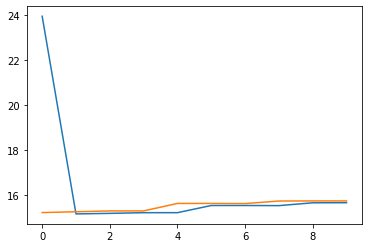


loss_model plot (blue: train | orange: eval


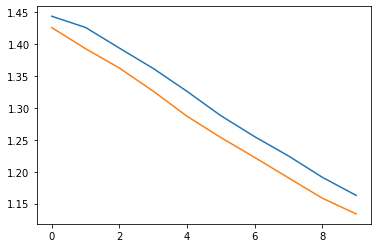


loss_compet plot (blue: train | orange: eval


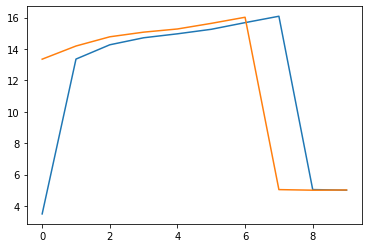

In [414]:
# Plot train and validation losses history
for metric in monitor_batchs.metrics_info:
    print(f"\n{metric} plot (blue: train | orange: eval")
    for set_i in monitor_batchs.sets_names:
        plt.plot(monitor_epochs.metrics[set_i][metric])
    plt.show()


#### Inspect predicted values

In [415]:
# Transform tensors to numpy arrays
y_pred = functional.softmax(predictions).detach().numpy()
y = labels.numpy()

# Display probas predicted
print('\nProbas predicted:\n', y_pred)

# Display the number of uniques probas (see the diversity of predictions)
print("\nQuantity of unique probas:", len(np.unique(functional.softmax(predictions).detach().numpy(), axis=0)))
print("\n6 first uniques:\n", np.unique(functional.softmax(predictions).detach().numpy(), axis=0)[:6])

# Transform array of predicted probas into vector of ints
y_pred = y_pred.argmax(axis=1)

# Values used
print('\nvalues used for predictions:', *np.unique(y_pred))

# Transform arrays into dataframes
df_results = pd.DataFrame({'y': y, 'y_pred': y_pred})

# Compute accuracy ratio
print(f'\nAccuracy model {round(100 * sum(y_pred == y)/len(y), 4)}%')

# Display value counts
print('\n\nPredictions:')
print(df_results['y_pred'].value_counts())
print('\ntarget:')
print(df_results['y'].value_counts())


Probas predicted:
 [[0.13200407 0.1639006  0.38750267 0.31659266]
 [0.13200407 0.1639006  0.38750267 0.31659266]
 [0.13200407 0.1639006  0.38750267 0.31659266]
 ...
 [0.13200407 0.1639006  0.38750267 0.31659266]
 [0.13200407 0.1639006  0.38750267 0.31659266]
 [0.13200407 0.1639006  0.38750267 0.31659266]]

Quantity of unique probas: 1

6 first uniques:
 [[0.13200407 0.1639006  0.38750267 0.31659266]]

values used for predictions: 2

Accuracy model 15.7374%


Predictions:
2    47638
Name: y_pred, dtype: int64

target:
0    23217
1    16407
2     7497
3      517
Name: y, dtype: int64


## Test model

On the test set (and no longer validation set)

In [416]:
# Test set
# --------
with torch.no_grad():
    # Reset batchs scores
    monitor_batchs.reset()

    for n_batch, (x, labels) in enumerate(dataloader_test):
        # Predict on the test set
        predictions = model(x)
        
        # Evaluate model and store metrics
        monitor_batchs.evaluate(predictions, labels, set_i='test')

# Compute & store: train and eval losses for the epoch
monitor_epochs.compute(monitor_batchs, ['test'])

# Display scores
monitor_epochs.print_scores(i_epoch=epoch)

Epoch 9 (train/eval): mod_loss (1.1629, 1.1339), comp_loss (5.0072, 5.0208), acc (15.6586, 15.7374)


### Save model's weights

In [ ]:
torch.save(model.state_dict(), 'weights/weights_new.pt')

### Compare with benchmarks preds

In [ ]:
m_train = Y_train.shape[0]
m_val = Y_val.shape[0]
m_test = Y_test.shape[0]

# Create numpy copy of target (from tensors)
y_train = Y_train.numpy().astype(np.int_)
y_val = Y_val.numpy().astype(np.int_)
y_test = Y_test.numpy().astype(np.int_)

# Random uniform train/test
random_preds_train = np.random.uniform(size=(Y_train.shape[0], 4))
random_preds_val = np.random.uniform(size=(Y_val.shape[0], 4))
random_preds_test = np.random.uniform(size=(Y_test.shape[0], 4))

# Create empty benchmark dumb
dumb_preds_train = np.zeros((m_train, 4)) + .49
dumb_preds_val = np.zeros((m_val, 4)) + .49
dumb_preds_test = np.zeros((m_test, 4)) + .49

# Benchmark dumb predict always 0 nights (the most )
dumb_preds_train[range(m_train), 0] = .5
dumb_preds_val[range(m_val), 0] = .5
dumb_preds_test[range(m_test), 0] = .5

# Evaluate preds
# Random
random_loss_train = competition_scorer(random_preds_train, y_train)
random_loss_val = competition_scorer(random_preds_val, y_val)
random_loss_test = competition_scorer(random_preds_test, y_test)
# Dumb
dumb_loss_train = competition_scorer(dumb_preds_train, y_train)
dumb_loss_val = competition_scorer(dumb_preds_val, y_val)
dumb_loss_test = competition_scorer(dumb_preds_test, y_test)

# Display results
print("Random preds")
print(round(random_loss_train, 4))
print(round(random_loss_val, 4))
print(round(random_loss_test, 4))

print("Dumb preds\n")
print(round(dumb_loss_train, 4))
print(round(dumb_loss_val, 4))
print(round(dumb_loss_test, 4))